In [53]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from shapely.geometry import Polygon
from scipy.ndimage import generic_filter

import cartopy.crs as ccrs 
import cartopy.feature as cfeature
 
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import cKDTree

import matplotlib.animation as animation

from IPython.display import HTML, display

from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

In [2]:
# data_dir = '/Users/jcai/Downloads/SWOT_7_21/'
data_dir = '/Users/Joyce Cai/Desktop/SWOT_smode/SWOT_l3_expert/'
files = os.listdir(data_dir)

In [3]:
# Define the latitude and longitude range of interest

lat_min, lat_max = 33, 38.5  # Replace with your actual latitude range
lon_min, lon_max = -127+360, -122+360  # Replace with your actual longitude range

In [4]:
# Setup the s-mode ops region

# Define the latitude and longitude of the turning points
lat_lon_points = [
    (-122.9246513748008,37.00017075060504),
    (-123.3600045167993,37.75374578880221),
    (-124.0035685865631,37.70690473657844),
    (-125.4381962505588,38.11405549886727),
    (-126.2343691354205,38.33265671629315),
    (-125.4928752370857,35.61490575897531),
    (-124.1744291387648,36.00856716614078),
    (-124.3527449926306,36.34480115296711),
    (-122.9246513748008,37.00017075060504),
]

# Create the polygon
polygon = Polygon(lat_lon_points)

# Extract the exterior coordinates of the polygon
exterior_coords = polygon.exterior.coords.xy

In [11]:
def ssha_daily_swot(track_dir,
                    ssha_alltime, u_alltime, v_alltime, zeta_alltime, Lon, Lat, idd,
                    lat_min, lat_max, lon_min, lon_max,
                    exterior_coords,
                   ):
    
    # Open the NetCDF file
    file_path = track_dir
    dataset = xr.open_dataset(file_path)
    
    # Use .where() to filter the data
    ssha_sliced = dataset['ssha'].where(
        (dataset['latitude'] >= lat_min) & (dataset['latitude'] <= lat_max) &
        (dataset['longitude'] >= lon_min) & (dataset['longitude'] <= lon_max),
        drop=True  # Drops the missing values from the result
    )
    
    ugos_sliced = dataset['ugos'].where(
        (dataset['latitude'] >= lat_min) & (dataset['latitude'] <= lat_max) &
        (dataset['longitude'] >= lon_min) & (dataset['longitude'] <= lon_max),
        drop=True  # Drops the missing values from the result
    )

    vgos_sliced = dataset['vgos'].where(
        (dataset['latitude'] >= lat_min) & (dataset['latitude'] <= lat_max) &
        (dataset['longitude'] >= lon_min) & (dataset['longitude'] <= lon_max),
        drop=True  # Drops the missing values from the result
    )

    
    # check out the time range
    time_2 = np.tile(dataset['time'],(ssha_sliced.num_pixels.size,1))
    mask = (dataset['latitude'] >= lat_min) & (dataset['latitude'] <= lat_max)
    
    time_sliced = time_2.T[mask]

    time_min_org = np.min(time_sliced)
    time_str = str(time_min_org)
    time_min = time_str[:19] # shorten the time string

    time_max_org = np.max(time_sliced)
    time_str = str(time_max_org)
    time_max = time_str[:19] # shorten the time string
    
    # get the vorticity normalized by coriolis force zeta = dv_dx - du_dy -----------------------
    dv_dx = np.gradient(vgos_sliced, axis=0)/2000
    du_dy = np.gradient(ugos_sliced, axis=1)/2000
    
    # Convert back to an xarray DataArray if needed
    dv_dx_da = xr.DataArray(dv_dx, dims=vgos_sliced.dims, coords=vgos_sliced.coords)
    du_dy_da = xr.DataArray(du_dy, dims=ugos_sliced.dims, coords=ugos_sliced.coords)
    
    zeta = dv_dx_da - du_dy_da
    
    # Earth's angular velocity in rad/s
    omega = 7.2921e-5

    # Assuming latitudes is your array of latitudes (in degrees)
    latitudes = ssha_sliced.latitude  # Replace with your actual latitude data

    # Convert latitude from degrees to radians
    latitudes_rad = np.deg2rad(latitudes)

    # Calculate the Coriolis parameter f at each latitude
    f = 2 * omega * np.sin(latitudes_rad)

    # If you need this as an xarray DataArray
    f_da = xr.DataArray(f, dims=latitudes.dims, coords=latitudes.coords)
    
    zeta_norm = zeta/f_da
    
    # save the value! ---------------------------------------------------------------------------
    # Concatenate along a new dimension called 'idx'
    
    ssha_sliced_exp = ssha_sliced.expand_dims(dim='idx', axis=-1)
    ugos_sliced_exp = ugos_sliced.expand_dims(dim='idx', axis=-1)
    vgos_sliced_exp = vgos_sliced.expand_dims(dim='idx', axis=-1)
    zeta_norm_exp = zeta_norm.expand_dims(dim='idx', axis=-1)
    
    Lon_exp = ssha_sliced["longitude"].expand_dims(dim='idx', axis=-1)
    Lat_exp = ssha_sliced["latitude"].expand_dims(dim='idx', axis=-1)
    
    if ssha_alltime is None:
        ssha_alltime = ssha_sliced_exp
        u_alltime = ugos_sliced_exp
        v_alltime = vgos_sliced_exp
        zeta_alltime = zeta_norm_exp
        Lon = Lon_exp
        Lat = Lat_exp
    else:
        ssha_alltime = xr.concat([ssha_alltime, ssha_sliced_exp], dim='idx')
        u_alltime = xr.concat([u_alltime, ugos_sliced_exp], dim='idx')
        v_alltime = xr.concat([v_alltime, vgos_sliced_exp], dim='idx')
        zeta_alltime = xr.concat([zeta_alltime, zeta_norm_exp], dim='idx')
        Lon = xr.concat([Lon, Lon_exp], dim='idx')
        Lat = xr.concat([Lat, Lat_exp], dim='idx')
         
    
    idd = idd + 1

    
    print(time_min)
    
    return ssha_alltime, u_alltime, v_alltime, zeta_alltime, Lon, Lat, time_min, time_max, idd

## start to iterate through all available file

In [12]:
# cycle 474:1:577
# noted: some cycle may only has one track, but we treat different tracks individually

# Setup the ssha and time_min and time_max to store all data

ssha_alltime = None
u_alltime = None
v_alltime = None
zeta_alltime = None
Lon = None
Lat = None

time_min_all = []
time_max_all = []

idd = 0

# cycle 491: track 13 no data in the region

for filename in os.listdir(data_dir):
    track_dir = os.path.join(data_dir, filename)
    
    XXX = filename[22:25] # cycle number 
           
    print(XXX)
    ssha_alltime, u_alltime, v_alltime, zeta_alltime, Lon, Lat, time_min, time_max, idd = ssha_daily_swot(track_dir,
                    ssha_alltime, u_alltime, v_alltime, zeta_alltime, Lon, Lat, idd,
                    lat_min, lat_max, lon_min, lon_max,
                    exterior_coords,
                   )

    time_min_all.append(time_min)
    time_max_all.append(time_max)


474
2023-03-29T08:50:20
474
2023-03-29T19:33:45
475
2023-03-30T19:24:21
476
2023-03-31T08:31:35
477
2023-04-01T19:05:37
478
2023-04-02T08:12:51
478
2023-04-02T18:56:15
479
2023-04-03T08:03:29
479
2023-04-03T18:46:53
480
2023-04-04T07:54:06
480
2023-04-04T18:37:30
481
2023-04-05T07:44:44
481
2023-04-05T18:28:08
482
2023-04-06T07:35:22
482
2023-04-06T18:18:46
483
2023-04-07T07:26:00
483
2023-04-07T18:09:24
484
2023-04-08T07:16:38
484
2023-04-08T18:00:03
485
2023-04-09T07:07:16
485
2023-04-09T17:50:41
486
2023-04-10T06:57:55
486
2023-04-10T17:41:19
487
2023-04-11T06:48:33
487
2023-04-11T17:31:57
488
2023-04-12T06:39:11
488
2023-04-12T17:22:35
489
2023-04-13T06:29:49
489
2023-04-13T17:13:13
490
2023-04-14T06:20:27
490
2023-04-14T17:03:51
491
2023-04-15T06:11:06
491
2023-04-15T16:54:29
492
2023-04-16T06:01:43
492
2023-04-16T16:45:07
493
2023-04-17T05:52:21
493
2023-04-17T16:35:45
494
2023-04-18T05:42:58
494
2023-04-18T16:26:23
495
2023-04-19T05:33:36
495
2023-04-19T16:17:00
496
2023-04-20T0

In [55]:
# Log of unusual file/track

# ID=2, flag=102 => No SSHa values available 


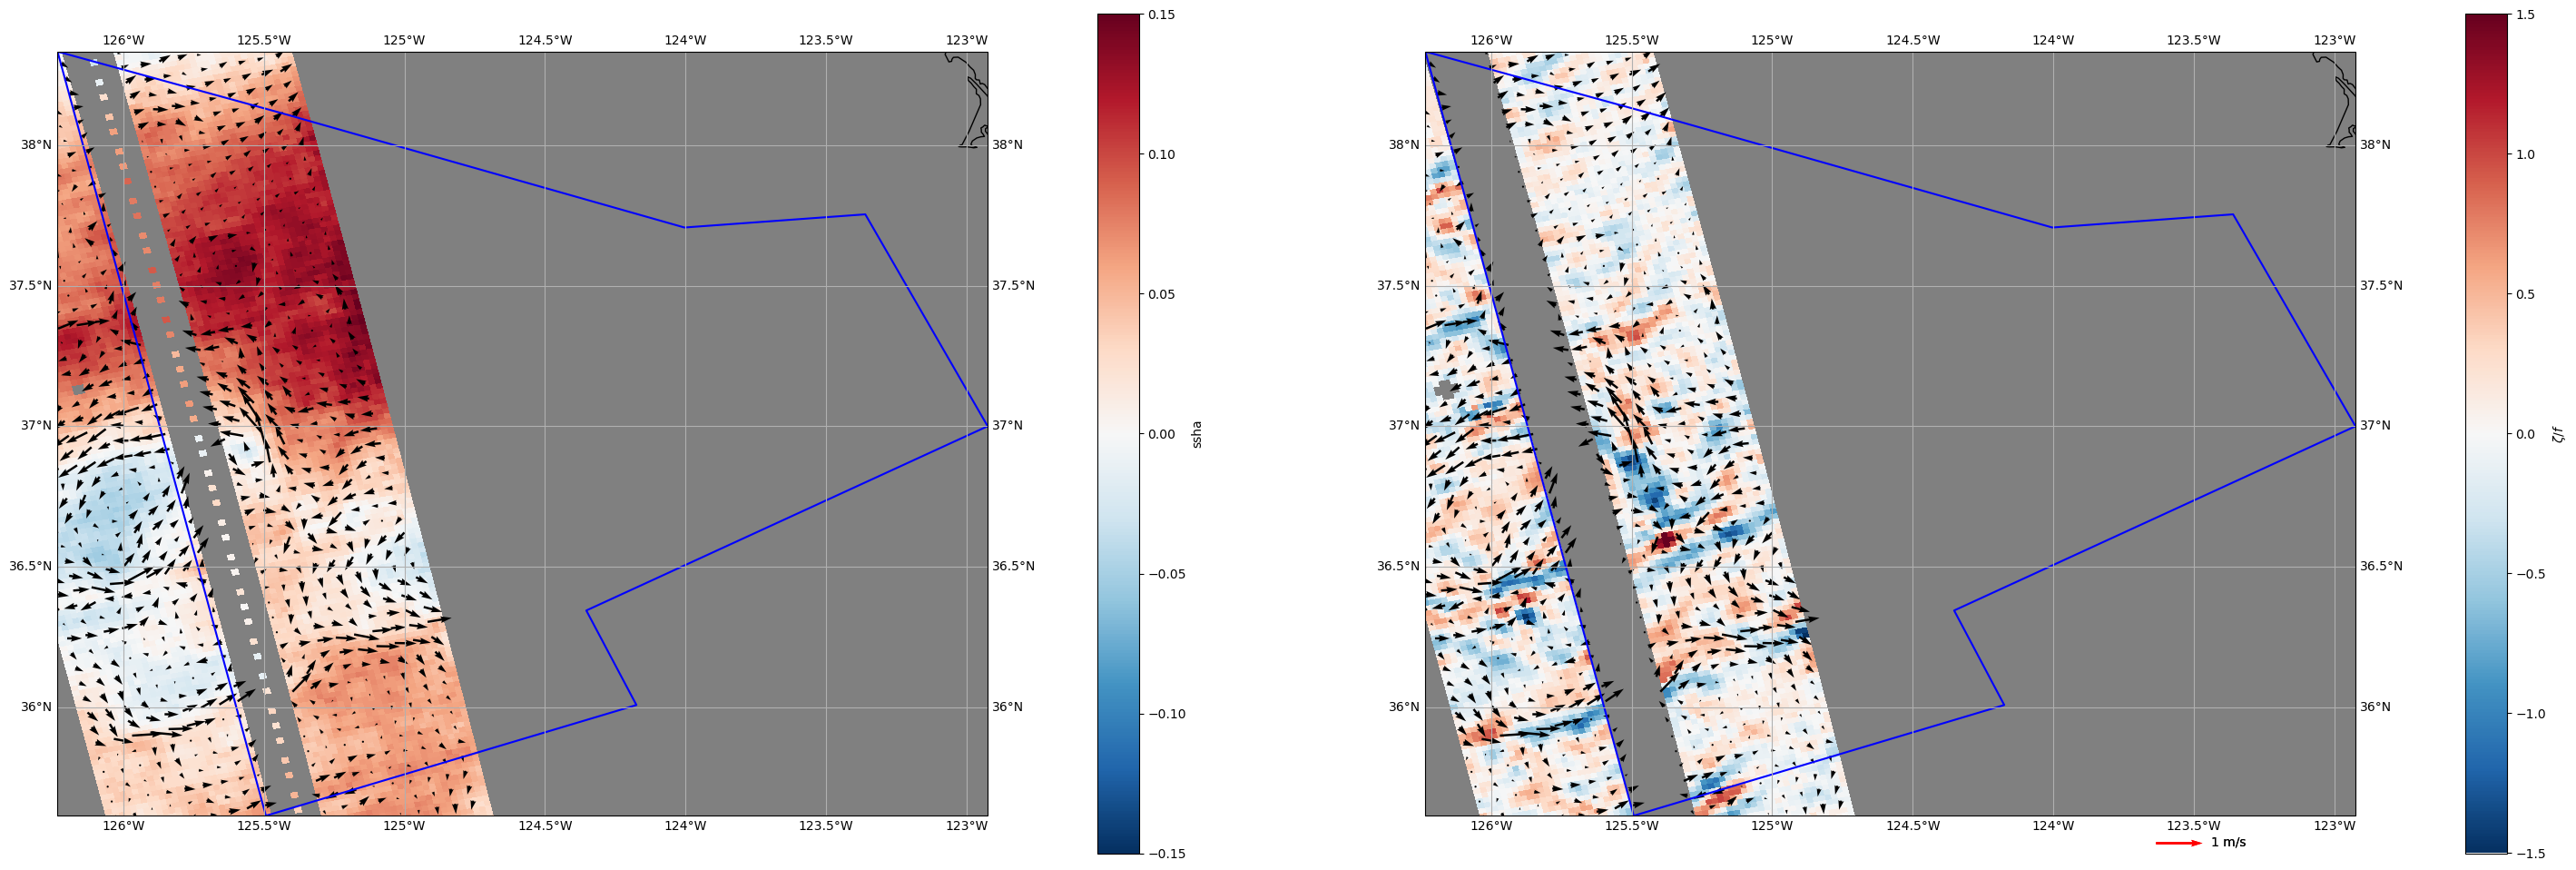

In [77]:
ID = 54

# Create the plot
fig, axs = plt.subplots(1,2, figsize=(35, 12), subplot_kw={'projection': ccrs.PlateCarree()},
                              gridspec_kw={'wspace': 0.25}
                              )

ax1 = axs[0]
# plot the ssha with velocity
ssha_plot = ax1.pcolormesh(Lon[:,:,ID], Lat[:,:,ID], ssha_alltime[:,:,ID], cmap='RdBu_r', shading='auto', vmin=-0.15, vmax=0.15)

# Plot the polygon
ax1.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())
# ax.fill(exterior_coords[0], exterior_coords[1], 'b', alpha=0.3, transform=ccrs.PlateCarree())

# Add coastlines and gridlines for better reference
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.gridlines(draw_labels=True)

# Set the background color to gray
ax1.set_facecolor('gray')  # Plot background

# Add colorbar
cbar = plt.colorbar(ssha_plot, ax=ax1, orientation='vertical', pad=0.1, fraction=0.05)
cbar.set_label('ssha')

# Define scale for quiver arrows
scale = 20  # Adjust the scale factor to fit your data
# Create a quiver plot with subsampled data
step = 3  # Adjust this step to reduce arrow density
Lon_one = Lon[:,:,ID]
Lat_one = Lat[:,:,ID]
quiver1 = ax1.quiver(Lon_one[::step, ::step], Lat_one[::step, ::step], u_alltime[::step, ::step, ID], v_alltime[::step, ::step, ID], scale=scale, color='black', transform=ccrs.PlateCarree())

# Add a reference scale bar for quiver arrows
scale_length = 1  # Length of the scale bar in data units
ax1.quiverkey(quiver1, X=0.8, Y=0.12, U=scale_length, label=f'{scale_length} m/s', labelpos='E', coordinates='figure', color='red')

# Set labels and title
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# ax.set_title(f'$\zeta$ with smoothed velocity ($0.02^\circ \\times 0.032^\circ$) \nTime Range: {time_min_all[ID]} to {time_max_all[ID]}')

# Zoom in on the polygon region
lon_min, lon_max = min(exterior_coords[0]), max(exterior_coords[0])
lat_min, lat_max = min(exterior_coords[1]), max(exterior_coords[1])
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Set initial title
title1 = ax1.set_title('')

#------------------------------------------------------------------------------------------------------------------

ax2 = axs[1] 
# plot the zeta with velocity
zeta_plot = ax2.pcolormesh(Lon[:,:,ID], Lat[:,:,ID], zeta_alltime[:,:,ID], cmap='RdBu_r', shading='auto', vmin=-1.5, vmax=1.5)

# Plot the polygon
ax2.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())
# ax.fill(exterior_coords[0], exterior_coords[1], 'b', alpha=0.3, transform=ccrs.PlateCarree())

# Add coastlines and gridlines for better reference
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.gridlines(draw_labels=True)

# Set the background color to gray
ax2.set_facecolor('gray')  # Plot background

# Add colorbar
cbar = plt.colorbar(zeta_plot, ax=ax2, orientation='vertical', pad=0.1, fraction=0.05)
cbar.set_label('$\zeta/f$')

# Define scale for quiver arrows
scale = 20  # Adjust the scale factor to fit your data
# Create a quiver plot with subsampled data
step = 3  # Adjust this step to reduce arrow density
Lon_one = Lon[:,:,ID]
Lat_one = Lat[:,:,ID]
quiver2 = ax2.quiver(Lon_one[::step, ::step], Lat_one[::step, ::step], u_alltime[::step, ::step, ID], v_alltime[::step, ::step, ID], scale=scale, color='black', transform=ccrs.PlateCarree())

# Add a reference scale bar for quiver arrows
scale_length = 1  # Length of the scale bar in data units
ax2.quiverkey(quiver2, X=0.8, Y=0.12, U=scale_length, label=f'{scale_length} m/s', labelpos='E', coordinates='figure', color='red')

# Set labels and title
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Zoom in on the polygon region
lon_min, lon_max = min(exterior_coords[0]), max(exterior_coords[0])
lat_min, lat_max = min(exterior_coords[1]), max(exterior_coords[1])
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Set initial title
title2 = ax2.set_title('')


plt.show()

In [78]:
print(time_min_all[ID])

2023-04-26T15:11:26


## Check out the movie of all available data

In [72]:
# Create directory to store frames if it doesn't exist
import os
if not os.path.exists('frames'):
    os.makedirs('frames')

# Define the range of IDs for the frames
frame_range = range(len(time_min_all))
# frame_range = range(5)

# Loop through each ID and save the frame
for ID in frame_range:
    # Create the plot
    fig, axs = plt.subplots(1, 2, figsize=(35, 12), subplot_kw={'projection': ccrs.PlateCarree()},
                            gridspec_kw={'wspace': 0.25})

    # Plot 1: SSHA with velocity
    ax1 = axs[0]
    ssha_plot = ax1.pcolormesh(Lon[:, :, ID], Lat[:, :, ID], ssha_alltime[:, :, ID], cmap='RdBu_r', shading='auto', vmin=-0.15, vmax=0.15)
    ax1.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS, linestyle=':')
    ax1.gridlines(draw_labels=True)
    ax1.set_facecolor('gray')
    cbar1 = plt.colorbar(ssha_plot, ax=ax1, orientation='vertical', pad=0.1, fraction=0.05)
    cbar1.set_label('SSHA')

    # Define scale for quiver arrows
    scale = 20  # Adjust the scale factor to fit your data
    step = 3  # Adjust this step to reduce arrow density
    Lon_subsampled = Lon[::step, ::step, ID]
    Lat_subsampled = Lat[::step, ::step, ID]
    u_subsampled = u_alltime[::step, ::step, ID]
    v_subsampled = v_alltime[::step, ::step, ID]

    quiver1 = ax1.quiver(Lon_subsampled, Lat_subsampled, u_subsampled, v_subsampled, scale=scale, color='black', transform=ccrs.PlateCarree())
    # Add a reference scale bar for quiver arrows
    scale_length = 1  # Length of the scale bar in data units
    ax1.quiverkey(quiver1, X=0.8, Y=0.12, U=scale_length, label=f'{scale_length} m/s', labelpos='E', coordinates='figure', color='red')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_extent([min(exterior_coords[0]), max(exterior_coords[0]), min(exterior_coords[1]), max(exterior_coords[1])], crs=ccrs.PlateCarree())
    title1 = ax1.set_title(f'Sliced SSHA \nTime Range: {time_min_all[ID]} to {time_max_all[ID]}')

    # Plot 2: Zeta with velocity
    ax2 = axs[1]
    zeta_plot = ax2.pcolormesh(Lon[:, :, ID], Lat[:, :, ID], zeta_alltime[:, :, ID], cmap='RdBu_r', shading='auto', vmin=-1.5, vmax=1.5)
    ax2.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS, linestyle=':')
    ax2.gridlines(draw_labels=True)
    ax2.set_facecolor('gray')
    cbar2 = plt.colorbar(zeta_plot, ax=ax2, orientation='vertical', pad=0.1, fraction=0.05)
    cbar2.set_label('$\zeta/f$')

    quiver2 = ax2.quiver(Lon_subsampled, Lat_subsampled, u_subsampled, v_subsampled, scale=scale, color='black', transform=ccrs.PlateCarree())
    # Add a reference scale bar for quiver arrows
    ax2.quiverkey(quiver2, X=0.8, Y=0.12, U=scale_length, label=f'{scale_length} m/s', labelpos='E', coordinates='figure', color='red')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_extent([min(exterior_coords[0]), max(exterior_coords[0]), min(exterior_coords[1]), max(exterior_coords[1])], crs=ccrs.PlateCarree())
    title2 = ax2.set_title(f'Geostrophic Vorticity $\zeta/f$ \nTime Range: {time_min_all[ID]} to {time_max_all[ID]}')

    # Save the frame
    plt.savefig(f'frames/frame_{ID:03d}.png')
    plt.close(fig)


In [ ]:
# ffmpeg -r 1 -i frames/frame_%03d.png -c:v libx264 -vf "fps=10,format=yuv420p" animation.mp4